In [1]:
!nvidia-smi

Fri Dec 23 23:24:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 45%   30C    P8    N/A /  75W |    469MiB /  4096MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow as tf

gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# Obraz - transfer learning - praca domowa
Ostatnia aktualizacja: 2022.12.10

Z dokumentacji [Keras](https://keras.io/guides/transfer_learning/): *Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.*

Głównym celem pracy domowej jest stworzenie klasyfikatora, który będzie odróżniał zdjęcia obiektów w wybranym przez nas zbiorze. Użyjemy do tego jednego z [gotowych modeli Keras](https://keras.io/api/applications/), wytrenowanego wcześniej na zbiorze Imagenet. 

Przydatne źródła:
- [transfer learning vgg16 + tf_flowers](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
- [Keras - transfer learning](https://keras.io/guides/transfer_learning/)

### Wybrany zbiór danych:

- [znaki drogowe](https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-1-million-images-for-classification). 


In [2]:
import h5py
filename = "dataset_ts_original.hdf5"

with h5py.File(filename, "r") as f:
    
    x_test = f['x_test'][()].astype('float32')
    x_train = f['x_train'][()].astype('float32')
    y_test = f['y_test'][()].astype('float32')
    y_train = f['y_train'][()].astype('float32')
    x_validation = f['x_validation'][()].astype('float32')
    y_validation = f['y_validation'][()].astype('float32')

### Zadanie 1: Wytrenuj model na swoich danych ###
**(Zadanie na ocenę 3)**

Wytrenuj wybrany model na swoich danych. Omów eksperyment i wyniki (100 słów). 

In [15]:
assert x_test.shape[1:] == x_train.shape[1:] == x_validation.shape[1:]
print(x_test.shape)
print(x_train.shape)
print(x_validation.shape)

(3111, 48, 48, 3)
(36288, 48, 48, 3)
(12440, 48, 48, 3)


In [6]:
# x_validation_resized = tf.image.resize(x_validation[:300], (150, 150)).numpy()
# x_test_resized = tf.image.resize(x_test[:50], (150, 150)).numpy()
# x_train_resized = tf.image.resize(x_train[:1500], (150, 150)).numpy()

In [2]:
x_train[0].shape

(48, 48, 3)

### Wczytaj wytrenowany model do klasyfikacji obrazu. ###
Może to być jeden z gotowych [modeli dostępnych w Keras](https://keras.io/api/applications/). Wczytujemy go z wytrenowanymi już wcześniej wagami na Imagenecie (weights='imagenet'). 

Model możemy wczytać bez ostatnich warstw (include_top=False) i dodać je potem ręcznie, dostosowane do liczby klas w naszym zbiorze. Imagenet ma 1000 klas, my prawdopodobnie będziemy mieć ich mniej. 

Pamiętaj, żeby wyłączyć lub ograniczyć trening części modelu z wytrenowanymi już wagami (trainable=False). 

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

base_model = VGG16(weights='imagenet', include_top=False, input_shape=x_train[0].shape)
base_model.trainable = False


In [10]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(150, activation='relu')
prediction_layer = layers.Dense(43, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 150)               76950     
                                                                 
 dense_1 (Dense)             (None, 43)                6493      
                                                                 
Total params: 14,798,131
Trainable params: 83,443
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
y_train.shape

(36288,)

In [74]:
import pandas as pd
y_train = pd.get_dummies(y_train).to_numpy()
y_validation = pd.get_dummies(y_validation).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

In [75]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
908/908 [==============================] - 41s 40ms/step - loss: 2.0640 - accuracy: 0.6008 - val_loss: 1.0568 - val_accuracy: 0.7152
Epoch 2/50
908/908 [==============================] - 35s 39ms/step - loss: 0.7532 - accuracy: 0.7740 - val_loss: 0.7749 - val_accuracy: 0.7852
Epoch 3/50
908/908 [==============================] - 35s 39ms/step - loss: 0.5510 - accuracy: 0.8295 - val_loss: 0.7730 - val_accuracy: 0.7834
Epoch 4/50
908/908 [==============================] - 35s 39ms/step - loss: 0.4541 - accuracy: 0.8551 - val_loss: 0.6933 - val_accuracy: 0.8143
Epoch 5/50
908/908 [==============================] - 35s 39ms/step - loss: 0.3894 - accuracy: 0.8763 - val_loss: 0.6481 - val_accuracy: 0.8330
Epoch 6/50
908/908 [==============================] - 35s 39ms/step - loss: 0.3391 - accuracy: 0.8892 - val_loss: 0.6649 - val_accuracy: 0.8325
Epoch 7/50
908/908 [==============================] - 35s 39ms/step - loss: 0.3023 - accuracy: 0.9006 - val_loss: 0.6673 - val_accuracy:

In [19]:
model.predict(x_train[:2])

1/1 [==============================] - 0s 23ms/step


array([[0.0000000e+00, 3.4126278e-36, 2.4456801e-34, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.3031604e-32,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 7.4905679e-31, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0549303e-37, 0.0000000e+00,
        6.7797821e-36, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.5613204e-38, 0.0000000e+00, 7.4406331e-34, 0.0000000e+00,
        0.0000000e+00, 7.9408963e-36, 0.0000000e+00],
       [4.1512739e-12, 6.6080820e-06, 7.8983510e-07, 1.5811435e-06,
        1.3831764e-05, 3.1484937e-08, 3.7811067e-11, 2.5975558e-10,
        3.4432971e-06, 2.7480095e-08, 1.0203946e-10, 5.3578051e-04,
        9.3616372e-06, 3.6711779e-06, 2.4849458e-08, 2.5991131

*TODO: omówienie (100 słów)*

omówienie will be here...

### Zadanie 2: Dodatkowe sieci ###
**(Zadanie na ocenę 4, po wykonaniu  zadania 1)**

Przeprowadź to samo na dwóch dodatkowych sieciach i omów wyniki (100 słów). 

Czyli jeśli w zadaniu 1 użyliśmy np. VGG to teraz wybieramy sobie np. ResNet i MobileNet. 

## Let's try pytorch lightning

https://www.kaggle.com/code/shreydan/resnet50-pytorch-lightning-kfolds

In [1]:
import h5py
filename = "dataset_ts_original.hdf5"

with h5py.File(filename, "r") as f:
    x_test = f['x_test'][()]
    x_train = f['x_train'][()]
    y_test = f['y_test'][()]
    y_train = f['y_train'][()]
    x_validation = f['x_validation'][()]
    y_validation = f['y_validation'][()]

In [2]:
import numpy as np
import torch

from torch.utils.data import TensorDataset, DataLoader


# train
tensor_x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2)
tensor_y_train = torch.Tensor(y_train)
#tensor_y_train = tensor_y_train.type(torch.FloatTensor) # doesn't help, need to do casting in training step
tensor_dataset_train = TensorDataset(tensor_x_train, tensor_y_train)

# val
tensor_x_val = torch.from_numpy(x_validation).permute(0, 3, 1, 2)
tensor_y_val = torch.Tensor(y_validation)
#tensor_y_val = tensor_y_val.type(torch.FloatTensor)
tensor_dataset_val = TensorDataset(tensor_x_val, tensor_y_val)

#test
tensor_x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2)
tensor_y_test = torch.Tensor(y_test)
#tensor_y_test = tensor_y_test.type(torch.FloatTensor) 
tensor_dataset_test = TensorDataset(tensor_x_test, tensor_y_test)

In [3]:
tensor_y_train.dtype

torch.float32

In [4]:
import pytorch_lightning as pl

class ResNet50Model(pl.LightningModule):
    def __init__(self, pretrained=True, in_channels = 3, num_classes = 16, lr=3e-4, freeze=False):
        super(ResNet50Model, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.lr = lr
        
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.Dropout(0.3),
            nn.Linear(128, self.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        
        
    def forward(self, x):
        return self.model(x)
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        
        preds = self.model(x)

        y = y.type(torch.LongTensor)
        x, y = x.to(device), y.to(device)
        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_epoch=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        preds = self.model(x)
        
        y = y.type(torch.LongTensor)
        x, y = x.to(device), y.to(device)
        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
    
    def test_step(self, batch, batch_idx):
        
        x,y = batch
        preds = self.model(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', self.test_acc, on_epoch=True)

In [5]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchmetrics
from sklearn.model_selection import StratifiedKFold
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.models import resnet50, ResNet50_Weights

freeze=False

In [6]:
device = torch.device("cuda:0")
num_folds = 4
kf = StratifiedKFold(num_folds)
lr = 3e-4
logs = dict()

for fold, (train_fold, val_fold) in enumerate(kf.split(X=x_train, y=y_train), start=1):
    train_dataloader = torch.utils.data.DataLoader(tensor_dataset_train,batch_size=64,num_workers=8)
    val_dataloader = torch.utils.data.DataLoader(tensor_dataset_val, batch_size=64,num_workers=8)
    test_dataloader = torch.utils.data.DataLoader(tensor_dataset_test, batch_size=128, num_workers=8)
    
    model = ResNet50Model(num_classes=43, freeze=False)
    trainer = pl.Trainer(accelerator='gpu', 
                         max_epochs=10,
                         callbacks=[
                         EarlyStopping(monitor="val_loss", 
                                       mode="min",
                                       patience=2)])
    
    model.hparams.lr = lr
    
    print(f"\n\n\n{'=='*20} FOLD {fold} / {num_folds} {'=='*20}")
    
    trainer.fit(model, train_dataloader, val_dataloader)
    metrics = trainer.logged_metrics
    trainer.test(model, test_dataloader)
    
    logs[f'fold{fold}'] = {
        'train_loss': metrics['train_loss_epoch'].item(),
        'val_loss': metrics['val_loss'].item(),
        'train_acc': metrics['train_acc_epoch'].item(),
        'val_acc': metrics['val_acc'].item()
    }
    
    print(f"Train Loss: {logs[f'fold{fold}']['train_loss']} | Train Accuracy: {logs[f'fold{fold}']['train_acc']}")
    print(f"Val Loss: {logs[f'fold{fold}']['val_loss']} | Val Accuracy: {logs[f'fold{fold}']['val_acc']}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs





======================================== FOLD 1 / 4 ========================================


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.8 M
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.103    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9980713725090027
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.0002568479103501886 | Train Accuracy: 1.0
Val Loss: 0.004727860447019339 | Val Accuracy: 0.9988746047019958


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.8 M
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.103    Total estimated model params size (MB)





======================================== FOLD 2 / 4 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9980713725090027
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.0002971006906591356 | Train Accuracy: 1.0
Val Loss: 0.007029504049569368 | Val Accuracy: 0.9982315301895142


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.8 M
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.103    Total estimated model params size (MB)





======================================== FOLD 3 / 4 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        test_acc             0.999035656452179
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.00028609790024347603 | Train Accuracy: 0.9999724626541138
Val Loss: 0.005856333766132593 | Val Accuracy: 0.9983118772506714


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.8 M
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.103    Total estimated model params size (MB)





======================================== FOLD 4 / 4 ========================================


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9993571043014526
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.0001943597017088905 | Train Accuracy: 1.0
Val Loss: 0.004916341044008732 | Val Accuracy: 0.9986334443092346


freeze=True

In [ ]:
device = torch.device("cuda:0")
num_folds = 4
kf = StratifiedKFold(num_folds)
lr = 3e-4
logs = dict()

for fold, (train_fold, val_fold) in enumerate(kf.split(X=x_train, y=y_train), start=1):
    train_dataloader = torch.utils.data.DataLoader(tensor_dataset_train,batch_size=64,num_workers=8)
    val_dataloader = torch.utils.data.DataLoader(tensor_dataset_val, batch_size=64,num_workers=8)
    test_dataloader = torch.utils.data.DataLoader(tensor_dataset_test, batch_size=128, num_workers=8)
    
    model = ResNet50Model(num_classes=43, freeze=True)
    trainer = pl.Trainer(accelerator='gpu', 
                         max_epochs=10,
                         callbacks=[
                         EarlyStopping(monitor="val_loss", 
                                       mode="min",
                                       patience=2)])
    
    model.hparams.lr = lr
    
    print(f"\n\n\n{'=='*20} FOLD {fold} / {num_folds} {'=='*20}")
    
    trainer.fit(model, train_dataloader, val_dataloader)
    metrics = trainer.logged_metrics
    trainer.test(model, test_dataloader)
    
    logs[f'fold{fold}'] = {
        'train_loss': metrics['train_loss_epoch'].item(),
        'val_loss': metrics['val_loss'].item(),
        'train_acc': metrics['train_acc_epoch'].item(),
        'val_acc': metrics['val_acc'].item()
    }
    
    print(f"Train Loss: {logs[f'fold{fold}']['train_loss']} | Train Accuracy: {logs[f'fold{fold}']['train_acc']}")
    print(f"Val Loss: {logs[f'fold{fold}']['val_loss']} | Val Accuracy: {logs[f'fold{fold}']['val_acc']}")

In [7]:
first_parameter = next(model.parameters())
input_shape = first_parameter.size()
input_shape

torch.Size([64, 3, 7, 7])

*TODO: omówienie (100 słów)*

omówienie will be here...

### Zadanie 3: Trening od zera i porównanie ###
**(Zadanie na ocenę 5, po wykonaniu zadania 1 i 2)**

Spróbuj skonstruować swój własny model i wytrenować go 'od zera' na tych samych danych. Porównaj i omów swój ekeperyment i wyniki (100 słów).

reference: https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [1]:
import h5py
filename = "dataset_ts_original.hdf5"

with h5py.File(filename, "r") as f:
    x_test = f['x_test'][()]
    x_train = f['x_train'][()]
    y_test = f['y_test'][()]
    y_train = f['y_train'][()]
    x_validation = f['x_validation'][()]
    y_validation = f['y_validation'][()]

In [3]:
import pandas as pd
y_train = pd.get_dummies(y_train).to_numpy()
y_validation = pd.get_dummies(y_validation).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import MaxPooling2D

cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=x_train[0].shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=16, kernel_size=3),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(150, activation='relu'),
    Dense(100,activation='relu'),
    Dense(43,activation = 'softmax'),    
])

In [11]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics =['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


callbacks = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [13]:
history = cnn_model.fit(
    x_train,
    y_train,
    batch_size=156,
    epochs=75,
    verbose=1,
    validation_data=(x_validation,y_validation),
    callbacks=callbacks
)

Epoch 1/75
233/233 [==============================] - 11s 28ms/step - loss: 3.3748 - accuracy: 0.5381 - val_loss: 0.6167 - val_accuracy: 0.8361
Epoch 2/75
233/233 [==============================] - 5s 20ms/step - loss: 0.5054 - accuracy: 0.8694 - val_loss: 0.3109 - val_accuracy: 0.9238
Epoch 3/75
233/233 [==============================] - 5s 21ms/step - loss: 0.2822 - accuracy: 0.9284 - val_loss: 0.2171 - val_accuracy: 0.9473
Epoch 4/75
233/233 [==============================] - 5s 20ms/step - loss: 0.1915 - accuracy: 0.9517 - val_loss: 0.1673 - val_accuracy: 0.9634
Epoch 5/75
233/233 [==============================] - 5s 20ms/step - loss: 0.1473 - accuracy: 0.9625 - val_loss: 0.1429 - val_accuracy: 0.9675
Epoch 6/75
233/233 [==============================] - 5s 20ms/step - loss: 0.1211 - accuracy: 0.9679 - val_loss: 0.1321 - val_accuracy: 0.9707
Epoch 7/75
233/233 [==============================] - 5s 20ms/step - loss: 0.1039 - accuracy: 0.9732 - val_loss: 0.1333 - val_accuracy: 0.971

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Train - Accuracy')

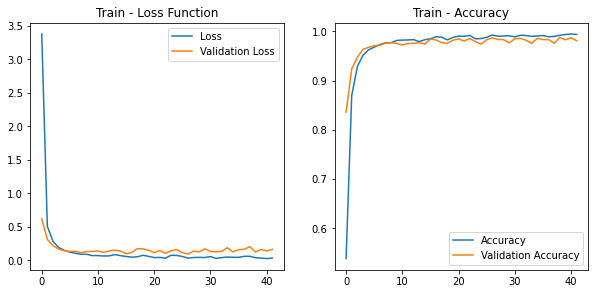

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Train - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [20]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.1542
Test Accuracy : 0.9826


omówienie will be here...

### Let's try transformers

https://keras.io/examples/vision/vit_small_ds/#build-the-vit   
https://arxiv.org/abs/2112.13492v1

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
NUM_CLASSES = 43
INPUT_SHAPE = (48, 48, 3)

import h5py
filename = "dataset_ts_original.hdf5"

with h5py.File(filename, "r") as f: 
    x_test = f['x_test'][()].astype('float32')
    x_train = f['x_train'][()].astype('float32')
    y_test = f['y_test'][()].astype('float32')
    y_train = f['y_train'][()].astype('float32')
    x_validation = f['x_validation'][()].astype('float32')
    y_validation = f['y_validation'][()].astype('float32')

In [17]:
# DATA
BUFFER_SIZE = 128
BATCH_SIZE = 16

# AUGMENTATION
IMAGE_SIZE = 48
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [6]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


In [7]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [8]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)


In [10]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [13]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [18]:
# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

Epoch 1/50
2042/2042 [==============================] - 239s 112ms/step - loss: 1.9745 - accuracy: 0.4562 - top-5-accuracy: 0.7725 - val_loss: 0.6602 - val_accuracy: 0.7812 - val_top-5-accuracy: 0.9760
Epoch 2/50
2042/2042 [==============================] - 228s 112ms/step - loss: 0.7682 - accuracy: 0.7563 - top-5-accuracy: 0.9636 - val_loss: 0.3270 - val_accuracy: 0.8851 - val_top-5-accuracy: 0.9909
Epoch 3/50
2042/2042 [==============================] - 228s 112ms/step - loss: 0.5121 - accuracy: 0.8373 - top-5-accuracy: 0.9829 - val_loss: 0.1869 - val_accuracy: 0.9325 - val_top-5-accuracy: 0.9961
Epoch 4/50
2042/2042 [==============================] - 228s 112ms/step - loss: 0.4011 - accuracy: 0.8747 - top-5-accuracy: 0.9883 - val_loss: 0.1303 - val_accuracy: 0.9573 - val_top-5-accuracy: 0.9967
Epoch 5/50
2042/2042 [==============================] - 228s 111ms/step - loss: 0.3457 - accuracy: 0.8935 - top-5-accuracy: 0.9914 - val_loss: 0.1158 - val_accuracy: 0.9631 - val_top-5-accurac

2042/2042 [==============================] - 224s 110ms/step - loss: 0.2123 - accuracy: 0.9364 - top-5-accuracy: 0.9957 - val_loss: 0.0706 - val_accuracy: 0.9758 - val_top-5-accuracy: 0.9989
Epoch 42/50
2042/2042 [==============================] - 224s 110ms/step - loss: 0.1987 - accuracy: 0.9407 - top-5-accuracy: 0.9960 - val_loss: 0.0877 - val_accuracy: 0.9694 - val_top-5-accuracy: 0.9989
Epoch 43/50
2042/2042 [==============================] - 224s 110ms/step - loss: 0.2156 - accuracy: 0.9356 - top-5-accuracy: 0.9953 - val_loss: 0.0579 - val_accuracy: 0.9810 - val_top-5-accuracy: 0.9992
Epoch 44/50
2042/2042 [==============================] - 224s 110ms/step - loss: 0.2056 - accuracy: 0.9381 - top-5-accuracy: 0.9959 - val_loss: 0.0590 - val_accuracy: 0.9780 - val_top-5-accuracy: 0.9994
Epoch 45/50
2042/2042 [==============================] - 224s 110ms/step - loss: 0.1936 - accuracy: 0.9415 - top-5-accuracy: 0.9963 - val_loss: 0.0568 - val_accuracy: 0.9851 - val_top-5-accuracy: 0.99

In [19]:
# Run experiments with the Shifted Patch Tokenization and Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
2042/2042 [==============================] - 250s 117ms/step - loss: 1.4083 - accuracy: 0.6236 - top-5-accuracy: 0.8829 - val_loss: 0.3523 - val_accuracy: 0.8878 - val_top-5-accuracy: 0.9915
Epoch 2/50
2042/2042 [==============================] - 238s 117ms/step - loss: 0.5716 - accuracy: 0.8191 - top-5-accuracy: 0.9782 - val_loss: 0.2834 - val_accuracy: 0.9110 - val_top-5-accuracy: 0.9950
Epoch 3/50
2042/2042 [==============================] - 238s 117ms/step - loss: 0.4254 - accuracy: 0.8666 - top-5-accuracy: 0.9876 - val_loss: 0.1230 - val_accuracy: 0.9587 - val_top-5-accuracy: 0.9986
Epoch 4/50
2042/2042 [==============================] - 238s 117ms/step - loss: 0.3106 - accuracy: 0.9054 - top-5-accuracy: 0.9926 - val_loss: 0.1232 - val_accuracy: 0.9614 - val_top-5-accuracy: 0.9981
Epoch 5/50
2042/2042 [==============================] - 238s 117ms/step - loss: 0.2796 - accuracy: 0.9151 - top-5-accuracy: 0.9937 - val_loss: 0.1256 - val_accuracy: 0.9587 - val_top-5-accurac

2042/2042 [==============================] - 238s 117ms/step - loss: 0.1545 - accuracy: 0.9550 - top-5-accuracy: 0.9969 - val_loss: 0.0735 - val_accuracy: 0.9799 - val_top-5-accuracy: 0.9989
Epoch 42/50
2042/2042 [==============================] - 238s 116ms/step - loss: 0.1677 - accuracy: 0.9515 - top-5-accuracy: 0.9968 - val_loss: 0.0452 - val_accuracy: 0.9851 - val_top-5-accuracy: 0.9994
Epoch 43/50
2042/2042 [==============================] - 238s 117ms/step - loss: 0.1595 - accuracy: 0.9539 - top-5-accuracy: 0.9965 - val_loss: 0.0787 - val_accuracy: 0.9741 - val_top-5-accuracy: 0.9983
Epoch 44/50
2042/2042 [==============================] - 238s 116ms/step - loss: 0.1628 - accuracy: 0.9520 - top-5-accuracy: 0.9971 - val_loss: 0.0760 - val_accuracy: 0.9782 - val_top-5-accuracy: 0.9986
Epoch 45/50
2042/2042 [==============================] - 238s 116ms/step - loss: 0.1656 - accuracy: 0.9511 - top-5-accuracy: 0.9974 - val_loss: 0.0752 - val_accuracy: 0.9722 - val_top-5-accuracy: 0.99

*TODO: omówienie (100 słów)*

omówienie will be here...